# Homework 3

### This is the solution of:
* Tor Djupman
* Isac Östman
* Felix Svedberg

$$\newcommand{\dx}{\,\mathrm{d}x}
\newcommand{\ldb}{\left\llbracket}
\newcommand{\rdb}{\right\rrbracket}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\tn}{|\mspace{-1mu}|\mspace{-1mu}|}
\newcommand{\IR}{\mathbb{R}}
$$

## Problem 1 ($L^2$-projection)


Let $0 = x_0 < x_1 < x_2 < \ldots < x_{N} = 1$ be a partition of the interval
$I = (0,1)$ into $N$ subintervals of equal length $h=1/N$.  Moreover,
let $\{ \lambda_j\}_{j=0}^{N}$ be the set of nodal/hat basis functions of $V_h$
associated with the $N+1$ nodes $x_j$, $j = 0,1\ldots, N$, such that
The $L^2$-projection reads: find $P_hf\in V_h$ such that
$$
    \int_I(f - P_h f) v \dx = 0 \qquad\text{for all }v\in V_h
$$
We consider three different functions
* $f_1(x)=x\sin (3\pi x)$
* $f_2(x)=2-10x$
* $f_3(x)=x(1-x)$

**a)** Write a script ${\texttt {AssembleMassMatrix1D(x)}}$ that computes the mass matrix. 

**b)** Write a corresponding function $\texttt{AssembleLoadVector(x,f)}$ which computes 
the load vector for a given function $f$. Make sure that you can easily switch (for example by adding another input variable) out the quadrature
rule (Trapezoid and Simpson) to approximate the integrals $\int_{I} f \varphi_i \dx$

Convince yourself that your code is correct by computing the $L^2$ projection of the given functions, and observe that they look similar to the original function when plotting in the same figure (with enough mesh points). You do not need to document this.

**c)** Write a function $\texttt{ComputeErrorL2(x,Pf,f)}$ which computes the error in $L^2$ norm, 
$$\|P_h f-f \|=\sqrt{\int_0^1(P_h f-f)^2 dx}.$$
Hint: use the equivalent formula
$$\|P_h f-f \|=\sqrt{\sum_{i=1}^{N} \int_{x_{i-1}}^{x_{i}}(P_h f-f)^2 dx},$$
and approximate the integrals in each subinterval using Simpson's rule.

**d)** Test your code by computing the $L^2$-projection $P_h f\in V_h$ for the three given functions by using the
Trapezoidal rule to compute the load vector. Test with different $N$ values. Do the errors converge as expected? Why?

**e)** Repeat **d)** using Simpson's rule to compute the load vector. What do you find and why?

__ANSWERS:__

__1 d)__
We know that the L2-error is second is second order accurate, i.e
\begin{align}
    ||f - P_{h}f||_{L^{2}(I)} \le  Ch^{2}||f''||_{L^{2}(I)}
\end{align}
This means that the EOC of $f_{1}$ and $f_{3}$ is simply 2. Meaning that halving the mesh size results in a decrease in the error by a factor 4. But what about $f_{2}$? Since this function is linear, the second derivative in the RHS becomes zero, thus we expect the error to be approximately zero for all mesh sizes. 

What happens when we use Trapezoidal quadrature to assemble the load vector? In table 1, we can clearly see that the expected EOC is not obtained from reducing the mesh size by half, especially for the linear function $f_{2}$. This is due to the fact that trapezoidal quadrature is only able to approximate the integral of linear functions exactly. The elements of the load vector
\begin{align}
    b_{i} = \int_{I}{f\phi_{i}dx} 
\end{align}
is an integral of a nonlinear function except for the case where $f$ is constant. Due to this, a higher-order error is introduced to the system, and the expected EOC is not obtained. 

__1 e)__
If we instead switch to Simpsons method to assemble the load vector, we can see in table 2 that the expected EOC is obtained. This is because Simpsons method can integrate functions up to cubic order exactly. We see the error reduction of order 4 for $f_{1}$ and $f_{3}$ and the approximately zero error for $f_{2}$.

### Code Snippets

In [2]:
# Array and stuff 
import numpy as np
# Linear algebra solvers from scipy
import scipy.linalg as la
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt
# We also need access to the colormaps for 3D plotting
from matplotlib import cm

def AssembleMassMatrix1D(x):
    # Number of intervals
    N = x.size-1
    #Allocate and initiate matrix
    M = np.zeros((N+1,N+1))

    # Compute volume contributions by iterating over 
    #    intervals I_0 to I_(N-1):
    for i in range(0,N):
        # Mesh  size
        h = (x[i+1]-x[i])
        # Compute local mass matrix
        M_loc = (h/6)*np.array([[2, 1],[1, 2]])
        # Write local matrix into global
        M[i, i] += M_loc[0, 0]
        # Add three more matrix entries
        M[i,i+1] += M_loc[0,1]
        M[i+1,i] += M_loc[1,0]
        M[i+1,i+1] += M_loc[1,1]
    return M

In [3]:
def AssembleLoadVector1D(x, f, quad):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate global load vector
    b = np.zeros(N+1)
    # 2) Compute volume contributions by iterating over intervals 
    #    I_1 to I_N:
    for i in range(1,N+1):
        # Mesh  size
        h = (x[i]-x[i-1])
        # Element load vector
        b_loc = np.zeros(2)
        # Apply quadrature rule to int f phi_{i-1} and int f phi_{i}
        # Trapezoidal
        if quad == 't':
            b_loc[0] = f(x[i-1])*h/2
            b_loc[1] = f(x[i])*h/2
        # Simpson
        elif quad == 's':
            m = (x[i]+x[i-1])/2
            b_loc[0] = h/6*(f(x[i-1])+2*f(m))
            b_loc[1] = h/6*(f(x[i])+2*f(m))
        
        # Add to global vector
        b[i-1] += b_loc[0]
        b[i] += b_loc[1]

    return b

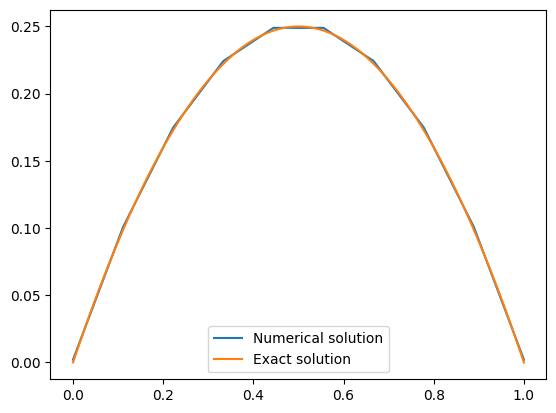

In [4]:
#Task 1b) Can be ignored since no need for documentation

f = lambda x : x*(1 - x)
N = 20
x = np.linspace(0,1,10)
x_anal = np.linspace(0,1,999)
M = AssembleMassMatrix1D(x)
b = AssembleLoadVector1D(x,f,'s') 
u = la.solve(M,b)
#print(eps)
plt.plot(x,u)
plt.plot(x_anal,f(x_anal))
plt.legend(["Numerical solution","Exact solution"])
plt.show()

In [5]:
def ComputeErrorL2(x,Pf,f):
    # Pf is an array consisting of the L2 projection evaluated on the mesh points
    # f is a function for f1, f2 or f3
    N = Pf.size-1
    err = 0
    for i in range(N):
        h = x[i+1]-x[i] 
        Pfl = Pf[i] # L2 projection value at x[i]
        Pfr = Pf[i+1] # L2 projection value at x[i+1]
        fl =  f(x[i]) #function value at x[i]
        fr = f(x[i+1]) # function value at x[i+1]
        m = (x[i]+x[i+1])/2
        Pfm = (Pfl+Pfr)*0.5 #An approximation of the projection-value corresponding to a midpoint.
        err = err+ ((Pfl-fl)**2+(Pfr-fr)**2+4*(Pfm-f(m))**2)*h/6 # Simpsons rule
        #print(err)
    return np.sqrt(err) 

In [6]:
def CalcProjectionL2(x,f,quad):
    M = AssembleMassMatrix1D(x)
    b = AssembleLoadVector1D(x,f,quad)
    u = la.solve(M,b)
    return u

In [7]:
#TASK 1d) and e)
import pandas as pd

# Functions
f1 = lambda x : x*np.sin(3*np.pi*x)
f2 = lambda x : 2 - 10*x
f3 = lambda x : x*(1 - x)
funs = [f1,f2,f3]
error_simp = np.zeros((4,3))
error_trap = np.zeros((4,3))
N_arr = [16, 32, 64, 128]

for i in range(0,len(N_arr)):
    x = np.linspace(0,1,N_arr[i])
    for j in range(0,len(funs)):
        #Projection using simpsons in load vector
        u_s = CalcProjectionL2(x,funs[j],'s')
        error_simp[i,j] = ComputeErrorL2(x, u_s, funs[j])
        
        #Projection using trapeziod in load vector
        u_t = CalcProjectionL2(x,funs[j],'t')
        error_trap[i,j] = ComputeErrorL2(x, u_t, funs[j])


#Table for task 1 d)       
data = {'f = xsin(3πx)': error_trap[:,0],'f = 2-10x': error_trap[:,1],
        'f = x(1-x)': error_trap[:,2]}
index = []
for i in range(0,len(N_arr)):
    index.append(f"h = 1/{N_arr[i]}")
    
df = pd.DataFrame(data, index=index)
display(df.style.set_caption("Table 1: Error using Trapezoid to assemble load vector.").format('{:.3e}'))


#Table for task 1 e)
data2 = {'f = xsin(3πx)': error_simp[:,0],'f = 2-10x': error_simp[:,1],
        'f = x(1-x)': error_simp[:,2]}

index2 = []
for i in range(0,len(N_arr)):
    index2.append(f"h = 1/{N_arr[i]}")
    
df = pd.DataFrame(data2, index=index2)
display(df.style.set_caption("Table 2: Error using Simpson to assemble load vector.").format('{:.3e}'))

,f = xsin(3πx),f = 2-10x,f = x(1-x)
h = 1/16,5.332e-02,7.551e-02,7.460e-03
h = 1/32,1.736e-02,2.542e-02,2.527e-03
h = 1/64,5.913e-03,8.773e-03,8.748e-04
h = 1/128,2.054e-03,3.065e-03,3.061e-04


,f = xsin(3πx),f = 2-10x,f = x(1-x)
h = 1/16,1.058e-02,6.412e-16,5.238e-04
h = 1/32,2.435e-03,7.853e-16,1.226e-04
h = 1/64,5.871e-04,6.088e-16,2.969e-05
h = 1/128,1.443e-04,5.907e-16,7.307e-06


## Problem 2  (The variational/weak formulation of Poisson's equation)

Note: Problem 2 is a theoretical exercise. You are not required to write any programming code.

**a)**
Derive the weak formulation for the steady-state advection-diffusion equation with variable coefficents, 
\begin{align*}
- (a(x)u(x)')' + c(x)u(x) = f \quad \text{in } I = (0,1)
\\
u(0) = 0, \quad u'(1) = 10,
\end{align*}
for two smooth functions $a(x)$ and $c(x)$ satisfying $a(x) \geqslant a_0 > 0$
and $c(x) \geqslant 0$.

**b)**
Derive a finite element method in suitable function spaces. 

**c)**
Derive the linear system for the above finite element method. 

__ANSWERS:__

__a)__

To find the weak formulation, we start by multiplying both sides with our test function $v$ and integrating all terms over $I$:

$$- \int_I (a \cdot u')'v \ dx + \int_I c \cdot u \cdot v \ dx = \int_I fv \ dx.$$
Next, we expand the first term on the LHS using integration-by-parts:

 $$-(a(1)u'(1)v(1)-a(0)u'(0)v(0)) + \int_I au'v' \ dx + \int_I c u v \ dx = \int_I fv \ dx$$

Now, we want to define our test space in which we will find our test function $v$. since we want our test function to be zero at the boundary $x = 1$ (to match the Dirichlet boundary condition) and to be well-behaved, we define our test space as: 
$$V_0 = \{ v \ : \ \|v\|_{L^2(I)} + \|v'\|_{L^2(I)} < \infty, v(0) = 0 \}.$$

So, since we require our test function to belong to this space, we consequently require $v(0) = 0$, meaning we can remove the first term on the LHS. Also using the Neumann BC $u'(1) = 10$, will result in the following weak formulation after some rearranging:

find $u(x) \in V $ such that 

$$ \int_I a(x)u'(x)v'(x) \ dx + \int_I c(x) u(x) v(x) \ dx = \int_I fv(x) \ dx + 10a(1)v(1)$$
$$ u(0) = 0, u'(1) = 10$$

where $v \in V_0 = V = \{ v \ : \ \|v\|_{L^2(I)} + \|v'\|_{L^2(I)} < \infty, v(0) = 0 \}, \ \  a(x) \geqslant a_0 > 0
\ $ and $ \ c(x) \geqslant 0$

__b)__

We divide the interval $I$ into $N$ intervals with $N+1$ total grid points, giving us the intervals $I_i, i = 1, \ 2, ... \ , N$

We now define the function $u_h(x) \approx u(x)$ which is continuous and piecewise linear. We also define, from the space of continuous piecewise linear functions on $I_i$:  
$$V_h = \{ v \ : \ v \in C^0(I), \ v|_{I_i} \ \in \  P_1(I_i) \  \text{with i} \  = 1, \ 2, \ ... \ , N\}$$ 

the space in which we want to find our solution $u_h$:

$$u_h \in V_{h,0} = \{ v \in V_h \ : \ v(0) = 0\} $$

Thus, our finite element method formulation is:

Find $u_h \in V_{h,0}$ such that

$$ \int_I a(x)u_h'(x)v_h'(x) \ dx + \int_I c(x) u_h(x) v_h(x) \ dx = \int_I fv_h(x) \ dx + 10a(1)v_h(1), \ \ v \in V_{h,0}$$



__c)__

Now, we declare that we can set our $v_h$ to be our nodal basis functions $\phi_i(x_j)$
since $\phi_i(x_j) \in V_{h,0}, \ $ where 
\begin{align}
  \varphi_i(x_j) =
  \left \{ 
  \begin{array}{l}
    1, \quad \mbox{if } i = j, \\
    0, \quad \mbox{if } i \neq j.
  \end{array}
  \right .
\end{align}

Furthermore, since $u_h \in V_{h,0}$ as well, $u_h$ can be written as a linear combination of the nodal basis functions:

$$u_h(x) = \sum_{j=1}^{N}\xi_j \phi_j(x),$$ 

which also means $$u_h'(x) = \sum_{j=1}^{N}\xi_j \phi_j'(x),$$

where $\xi_j$ are the weights, which are to be determined. Note, we do not include $\phi_0$ because of our Dirichlet BC. 

From this, our FEM formulation becomes: 

$$a(x)\sum_{j=1}^{N}\int_I \xi_j \phi_j' \phi_i' \ dx + c(x)\sum_{j=1}^{N}\int_I \xi_j \phi_j \phi_i \ dx = \int_I f \phi_i \ dx + 10a(1) \phi_N, \ \ \ i,j = 1,2, \cdots , N $$

So, we see that we have our stiffness and mass matrix on the LHS, each multiplied with our functions $a(x)$ and $c(x)$ respectively. In matrix form, this system looks like:

$$a(x) \begin{bmatrix}
\int_I \phi'_1 \phi'_1 & \cdots & \int_I \phi'_1 \phi'_N \\
\int_I \phi'_2 \phi'_1 & \cdots & \int_I \phi'_2 \phi'_N \\
\vdots & \ddots & \vdots \\
\int_I \phi'_N \phi'_1 & \cdots & \int_I \phi'_N \phi'_N
\end{bmatrix}
\begin{bmatrix}
\xi_1 \\
\xi_2 \\
\vdots \\
\xi_N
\end{bmatrix} 
+ 
c(x) \begin{bmatrix}
\int_I \phi_1 \phi_1 & \cdots & \int_I \phi_1 \phi_N \\
\int_I \phi_2 \phi_1 & \cdots & \int_I \phi_2 \phi_N \\
\vdots & \ddots & \vdots \\
\int_I \phi_N \phi_1 & \cdots & \int_I \phi_N \phi_N
\end{bmatrix}
\begin{bmatrix}
\xi_1 \\
\xi_2 \\
\vdots \\
\xi_N
\end{bmatrix} = \begin{bmatrix}
\int_I f \phi_1 \\
\int_I f \phi_2 \\
\vdots \\
\int_I f \phi_N
\end{bmatrix} + 10a(1) \phi_N$$

## Problem 3 (A 1D Finite Element Solver)

**a**) For $u(x) = x + \cos(2\pi x)$, compute a right-hand side $f$ and boundary values $g_R$, $g_N$
such that $u(x)$ solves the two-point boundary value problem on $I = [0,1]$ given by
\begin{gather*}
-u''= f, \quad 0<x<1, 
\\
u'(0)=-g_N, \quad u'(1)= (g_R - u(1))
\end{gather*}
a Neumann boundary condition on the left end point and a Robin boundary condition on the right end point.

**b)** Write down the weak form and then the finite element method, and be precise with the function spaces. Implement a finite element solver for this two-point boundary problem. 
Use uniform meshes with $h=1/N$ for $N = 4, 8, 16, 32, 64, 128$ and
compare the numerical solution $u_h$ with the exact solution $u(x)$
by plotting $u_h$ for $N = 4, 8, 16, 128$ and $u$ into the same figure.

**c)** Define the energy norm $\tn v \tn$ for $v \in V$ for this problem. Assuming that you can integrate the
right hand side $\int_I f v_h$ **exactly** for $v \in V_h \subset V$, show that the energy error satisfies
\begin{align*} 
 \tn u-u_h\tn^2=\tn u\tn^2-\tn u_h\tn^2     \quad\quad\quad\quad\quad\quad(1)
\end{align*}
by exploiting the Galerkin orthogonality. Hint: there is a similar identity in the lecture notes. You may follow the same procedure for the proof, but note that the energy norm here has a different expression.

Next, show that the following identity holds: 
\begin{align*}
\tn u_h\tn^2 =  U^T A U              \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad (2)
\end{align*}
where $U$ is the  coefficient vector corresponding to $u_h = \sum_{i=0}^{N} U_i \varphi_i$ and $A$ is the stiffness matrix for the problem at hand (including the contribution from the boundary).

**d)** For the given $N$ in b), compute the errors in the follwoing norms

* a) The maximum norm 
* b) The energy norm  

present the results in log-log plots (error versus $h$) and specify the convergence rate. Do they converge as expected?

Hint: use (1) to compute the error in the energy norm (be careful with the squares). For the first term in the right-hand side of (1), you can use a composite quadrature. For the second term in the right-hand side of (1), you can use the formula given in (2). 

Hint: (1) only holds if the load vector is computed exactly. When you approximate the integrals in the load vector, use a very accurate quadrature. 


__ANSWERS:__
$g_N = -1$, $g_R = 3$, $ f = 4 \pi^2 \cos (2 \pi x) $

__a)__ We have that $u(x) = x + \cos (2 \pi x)$, thus
\begin{align*}
    f &= -u'' = 4\pi^2 \sin (2\pi x), \quad 0< x < 1 \\
    g_N &= -u'(0) = 1 - 2 \pi \sin (2 \pi \times 0) = 1 \\
    g_R &= u'(1) + u(1) = 1 + 1 + 1 = 3
\end{align*}

__b)__ Weak form:

Find $u \in V_0$ such that,
$$
    \int_I u' v' dx + u(1) v(1) = \int_I f v dx + g_R v(1) + g_N v(0), \quad \forall v \in V_0 \quad \quad (1)
$$
where,
$$
    V_0 = \{v : \| v \|_{L^2(I)} < \infty, \, \| v' \|_{L^2(I)} < \infty \}
$$

Finite element:

Let $I_i = [\ x_{i-1}, x_i ]\ $, where $i = 1, 2, ..., N$. Find $u_h \in V_{h,0}$ such that,
$$
    \int_{I} u'_h v'_h dx + u_h(1) v_h(1) = \int_I f v_h dx + g_R v_h(1) + g_N v_h(0), \quad \forall v_h \in V_{h,0} \quad \quad (2)
$$
where,
$$
    V_{h,0} = \{ v : v \in C^0(I), \, v |_{I_i} \in P_1(I_i) \quad \text{with} \quad i = 1, ..., N \}.
$$
Which is equivalent to,
$$
    \int_{I} u'_h \phi'_i dx + u_h(1) \phi_i(1) = \int_I f \phi_i dx + g_R \phi_i(1) + g_N \phi_i(0)
$$
where,
\begin{align*}
    u_h &= \sum^N_{j=0} \xi_j \phi_j(x) \\
    \phi_k(x) &= 
    \left\{
    \begin{array}{cc}
     \frac{x - x_{k-1}}{h_i}, & x \in I_i \\
     \frac{x_{k+1} - x}{h_i}, & x \in I_{i+1} \\
     0, & \text{otherwise}
    \end{array}
    \right.
\end{align*}

An analytical versus numerical plot can be seen below. There, it can be seen that the numerical result converges to the analytical result for larger N.

__c)__ We define the energy norm, from Eq. (1), as
$$
    ||| v ||| = \left[ \int_I (v')^2 dx + v(1)^2 \right]^{1/2}
$$
Thus, we can show that,
$$
    ||| u - u_h |||^2 = ||| u |||^2 - ||| u_h |||^2
$$
But before that, we have from Eq.(1):
$$
    \int_I u' v' dx + u(1) v(1) = \int_I f v dx + g_R v(1) + g_N v(0), \quad \forall v \in V_0,
$$
and from Eq.(2):
$$
    \int_I u_h' v' dx + u_h(1) v(1) = \int_I f v dx + g_R v(1) + g_N v(0), \quad \forall v \in V_{h,0} \subset V_0,
$$
Subtracting the second with the first we get the relation:
$$
    \int_I (u' - u'_h) v' dx + ( u(1) - u_h(1) ) v(1) = 0 \quad \forall v \in V_{h,0} \quad \quad (3).
$$


Back to the main task, we get that,
\begin{align*}
    ||| u - u_h |||^2 &= \int_I (u' - u'_h)^2 dx + \left( u(1) - u_h(1) \right)^2 = \int_I (u' - u'_h)u' dx + \left( u(1) - u_h(1) \right)u(1) - \int_I (u' - u'_h) u'_h dx - \left( u(1) - u_h(1) \right) u_h(1) = \\ 
    &\overset{(i)}{=} \int_I (u')^2 dx - \int_I u' u'_h dx + \int_I (u' - u'_h) u'_h dx + u(1)^2 - u(1)u_h(1) + \left( u(1) - u_h(1) \right) u_h(1) = \\
    &= \int_I (u')^2 dx + u(1)^2 - \int_I (u_h')^2 dx - u_h(1)^2 = ||| u |||^2 - ||| u_h |||^2.
\end{align*}
In (i) we have that $u_h \subset V_{h, 0}$ and therefore we can use Eq.(3).

Using that $u_h = \sum^N_{i=0} U_i \phi_i$ and that $A_{ij} = \int_I \phi'_i(x) \phi'_j(x) dx + \phi_i(1) \phi_j(1)$ we get that,
\begin{align*}
    U^T A U = \sum^N_{i=0} \sum^N_{j=0} U_i A_{ij} U_j = \sum^N_{i=0} \sum^N_{j=0} \left[ \int_I U_i \phi'_i(x) U_j \phi'_j(x) dx + U_i \phi'_i(1) U_j \phi'_j(1) \right] = \int_I (u'_h)^2 dx + u_h(1)^2 = ||| u_h |||^2
\end{align*}
Thus, $ ||| u_h |||^2 = U^T A U$.

__d)__ From the final figure below, we see that the energy norm has a convergence rate of $\mathcal{O}(h)$, and the max norm $\mathcal{O}(h^2)$. According to the theory, we expect the energy norm to exhibit first-order convergence. This is from the Apriori error estimate theorem, given that the boundary terms do not change the convergence rates. 

For the max norm, we expect the error not to scale better than the composite quadrature used to calculate $u_h$. Because Simpsons method is used, and that Simpsons scales like $\mathcal{O}(h^2)$, the max norm of the error should be limited by $\mathcal{O}(h^2)$. However, other factors could play a role here.


In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

In [3]:
def AssembleStiffnessMatrix1D(x):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate matrix
    A = np.zeros((N+1, N+1))

    # 2) Compute volume contributions by iterating over 
    #    intervals I_0 to I_(N-1):
    for i in range(0,N):
        # Mesh  size
        h = x[i+1]-x[i]
        # Compute local stiffness matrix
        A_loc = 1/h*np.array([[1, -1],[-1, 1]])
        # Write local matrix into global
        A[i, i] += A_loc[0, 0]
        # Add three more matrix entries
        A[i, i+1] += A_loc[0, 1]
        A[i+1, i] += A_loc[1, 0]
        A[i+1, i+1] += A_loc[1, 1]
    
    # 3) Compute natural boundary contributions
    # Add Robin on the right
    A[N, N] += 1
    
    return A

In [4]:
def AssembleLoadVector1D(x, f, g_N, g_R):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate global load vector
    b = np.zeros(N+1)
    # 2) Compute volume contributions by iterating over intervals 
    #    I_0 to I_(N-1):
    for i in range(0,N):
        h = x[i+1] - x[i]
        b_loc = np.zeros(2)

        m = (x[i+1] + x[i])/2
        b_loc[0] = h/6*(f(x[i]) + 2*f(m))
        b_loc[1] = h/6*(f(x[i+1]) + 2*f(m))

        # Add to global vector
        b[i] += b_loc[0]
        b[i + 1] += b_loc[1]

    # 3) Incorporate boundary values
    # Neumann
    b[0] += g_N
    # Robin
    b[N] += g_R

    return b

In [5]:
# Declarations
g_N = -1
g_R = 3
f = lambda x: 4*np.pi**2*np.cos(2*np.pi*x)
N_list = [4, 8, 16, 128]
err_E = np.zeros(len(N_list))
err_max = np.zeros(len(N_list))

# Analytical solution
x_analytic = np.linspace(0,1,1000)
u_analytic = lambda x: x + np.cos(2*np.pi*x)

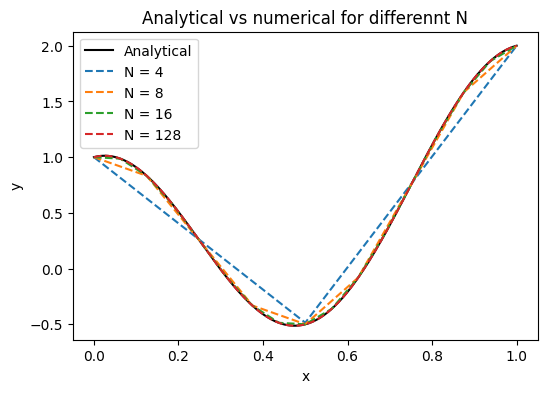

In [6]:
plt.figure(figsize = [6,4])
plt.plot(x_analytic, u_analytic(x_analytic), "-", color='black')
legend = ["Analytical"]

for i,N in enumerate(N_list):
    x = np.linspace(0,1,N+1)
    # Assemble A and b
    A = AssembleStiffnessMatrix1D(x)
    b = AssembleLoadVector1D(x, f, g_N, g_R)
    
    # Solve to find num. solution
    u_h = la.solve(A,b)

    # Plot
    plt.plot(x, u_h, "--")
    legend.append(f"N = {N}")
    
plt.legend(legend)
plt.title("Analytical vs numerical for differennt N")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
## d) functions
def energy_norm_exact(u, u_prim_2):
    x = np.linspace(0, 1, 1001)
    #Calc Energy norm for exact solution
    u_norm = (u(1))**2
    for i in range(0, x.size-1):
        # Using Simpsons
        h = x[i+1] - x[i]
        xm = (x[i+1] + x[i])/2
        u_norm += h/6*(u_prim_2(x[i]) + 4*u_prim_2(xm) + u_prim_2(x[i+1]))

    return u_norm

def error_energy_norm(u_norm, u_h, A):
    u_h_norm = u_h @ A @ u_h
    return np.sqrt(np.abs(u_norm - u_h_norm))

def error_max_norm(u_h, u, x):
    j = 0
    max_norm = 0
    for i in range(0,x.size-1):
        h = x[i+1] - x[i]
        x_step = np.linspace(x[i], x[i+1], 10)
        for j in range(10):
            u_h_func = u_h[i]*(x[i+1] - x_step[j])/h + u_h[i+1]*(x_step[j] - x[i])/h
            if max_norm < np.abs(u(x_step[j]) - u_h_func):
                max_norm = np.abs(u(x_step[j]) - u_h_func)
            
    return max_norm

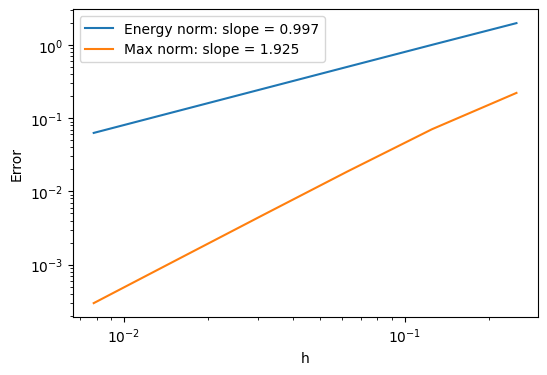

In [8]:
## d) "main" code
# Calculating the exact energy norm:
u_analytic = lambda x: x + np.cos(2*np.pi*x)
u_prim_2 = lambda x: (1 - 2*np.pi*np.sin(2*np.pi*x))**2
u_Enorm = energy_norm_exact(u_analytic, u_prim_2)

# Variables and initializations
N_list = [4, 8, 16, 32, 64, 128]
h = np.zeros(len(N_list))
for i,N in enumerate(N_list):
    h[i] = 1/N
err_E = np.zeros(len(N_list))
err_max = np.zeros(len(N_list))

# Calculating the error of the norms for different N:
for i,N in enumerate(N_list):
    x = np.linspace(0,1,N+1)

    A = AssembleStiffnessMatrix1D(x)
    b = AssembleLoadVector1D(x, f, g_N, g_R)
    u_h = la.solve(A,b)

    # Errors using max and energy norm
    err_E[i] = error_energy_norm(u_Enorm, u_h, A)
    err_max[i] = error_max_norm(u_h, u_analytic, x)

# Slope of error
q_E = np.polyfit(np.log(h), np.log(err_E), 1)[0]
q_max = np.polyfit(np.log(h), np.log(err_max), 1)[0]

# Plot result
plt.figure(figsize=[6,4])
plt.loglog(h, err_E)
plt.loglog(h, err_max)

plt.xlabel("h")
plt.ylabel("Error")
plt.legend([f"Energy norm: slope = {q_E:.03f}", f"Max norm: slope = {q_max:.3f}"])

plt.show()